# Generative model

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import igraph as ig
import dionysus as d

In [106]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = 10, 6

In [5]:
d.__version__

'2.0.7.dev0'

In [6]:
import dill

In [7]:
import multiprocessing
from dask.distributed import Client

In [8]:
from zigzag import *

In [9]:
from sliced_wasserstein import diagram_array, SW_approx

In [123]:
from network2tikz import plot

## Random network generation

In [124]:
def edge_presences(T, f):
    density = np.sin(f * np.arange(T)) + 1
    density /= np.sum(density)
    samplesize = np.random.randint(T//2)
    times = np.random.choice(np.arange(T), size=samplesize, replace=False, p=density)
    times = np.sort(times)
    return times

In [190]:
basegraph = ig.Graph.Erdos_Renyi(7, 0.9)

In [191]:
T = 5
g = ig.Graph()
g.add_vertices(len(basegraph.vs))
for e in basegraph.es:
    times = np.random.randint(0, T, T//2)
    for t in times:
        g.add_edge(e.source, e.target, time=t)

In [192]:
subgs = []
for t in np.unique(g.es["time"]):
    subgs.append(g.subgraph_edges(g.es.select(time_eq=t), delete_vertices=False))

In [193]:
visual_style = {}
visual_style["vertex_size"] = 0.3
visual_style["vertex_color"] = "blue"
visual_style["vertex_opacity"] = .7
#visual_style["edge_curved"] = 0.1
layout = basegraph.layout()
layout_dict = {}
for i, l in enumerate(layout):
    layout_dict[i] = l
visual_style["layout"] = layout_dict
visual_style["canvas"] = (4,4)
visual_style["margin"] = 1
for i, subg in enumerate(subgs):
    plot(subg, "network{0}.tex".format(i), **visual_style)

In [98]:
T = 200
f = 15/T
times = edge_presences(T, f)

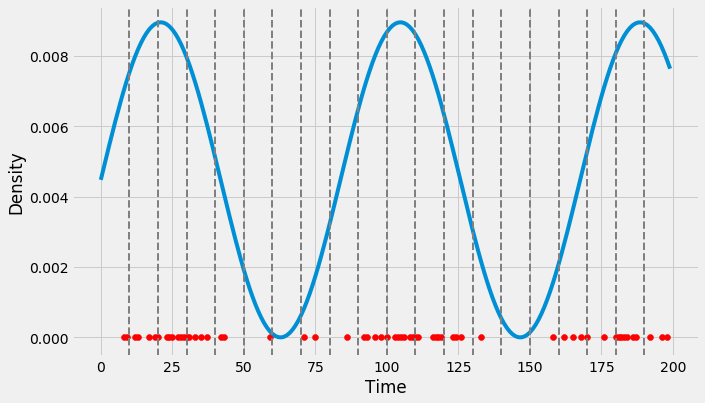

In [122]:
def density(t):
    return np.sin(f*t) + 1

fig, ax = plt.subplots()
ax.plot(density(np.arange(T))/np.sum(density(np.arange(T))))
ax.set_xlabel("Time")
ax.set_ylabel("Density")
ax.scatter(times, np.repeat(0, len(times)), color="red")
for x in range(10, 200, 10):
    ax.axvline(x=x, linestyle='--', linewidth=2, color="grey")
fig.savefig("density.pdf", transparent=True, pad_inches=0.3, bbox_inches="tight")

Text(0.5,0,'Time')

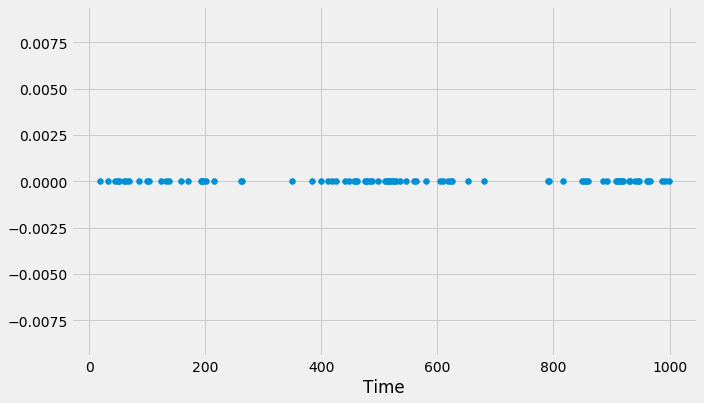

In [85]:
fig, ax = plt.subplots()
ax.scatter(times, np.repeat(0, len(times)))
ax.set_xlabel("Time")

In [68]:
len(basegraph.es), len(g.es)

(8, 16)

In [70]:
g.summary()

'IGRAPH U--- 5 16 -- \n+ attr: time (e)'

## Temporal partitioning

In [ ]:
wins = sliding_windows(g, 0.05)

In [ ]:
len(wins)

## Zigzag persistence

In [ ]:
(f, t) = presence_times(wins[0])

In [ ]:
zz, dgms, cells = d.zigzag_homology_persistence(f, t)

In [ ]:
client = Client()
dgms = client.map(zigzag_network, wins)
dgms = client.gather(dgms)

In [ ]:
pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
dgms = pool.map(zigzag_network, wins)

In [ ]:
pool.terminate()

In [ ]:
dgms

## Sliced Wasserstein kernel

In [ ]:
zzdgms1 = [dgm[1] for dgm in zzdgms if len(dgm) > 1]

In [ ]:
zzgram1 = np.array([[SW_approx(zzdgms1[i], zzdgms1[j], 10)
                     for i in range(len(zzdgms1))] for j in range(len(zzdgms1))])

In [ ]:
wrcfdgms1 = [dgm[1] for dgm in wrcfdgms if len(dgm) > 1]
wrcfgram1 = np.array([[SW_approx(wrcfdgms1[i], wrcfdgms1[j], 10)
                       for i in range(len(wrcfdgms1))] for j in range(len(wrcfdgms1))])

## Bottleneck distance

In [ ]:
client = Client()
distmat = []
for dgm in dgms1:
    distmat.append(client.map(lambda x: d.bottleneck_distance(x, dgm), dgms1))

In [ ]:
distmat = np.array(client.gather(distmat))
distmat

## Clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering

In [58]:
clf = AgglomerativeClustering(n_clusters=10, affinity="precomputed", linkage="average")

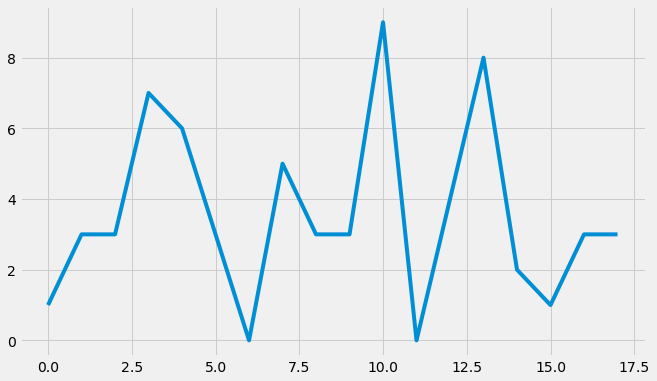

In [59]:
clf.fit(zz_gram1)
plt.plot(clf.labels_)

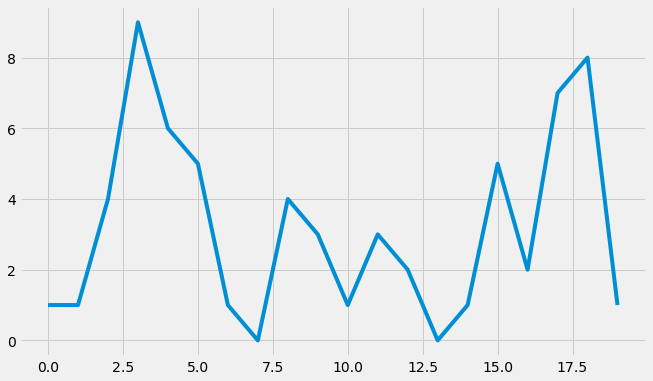

In [60]:
clf.fit(wrcf_gram1)
plt.plot(clf.labels_)

In [61]:
from sklearn.svm import OneClassSVM

In [62]:
clf = OneClassSVM(kernel='precomputed')

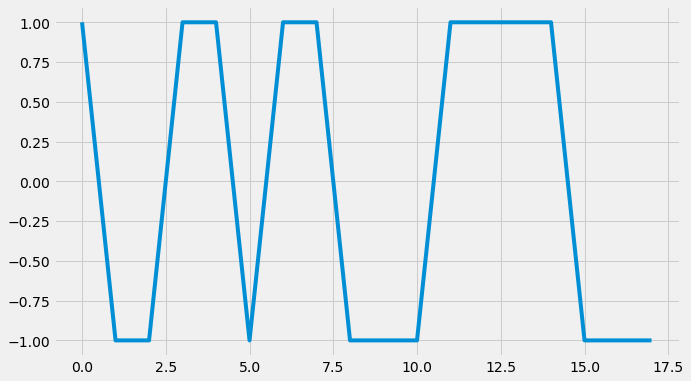

In [63]:
clf.fit(zz_gram1)
plt.plot(clf.predict(zz_gram1))

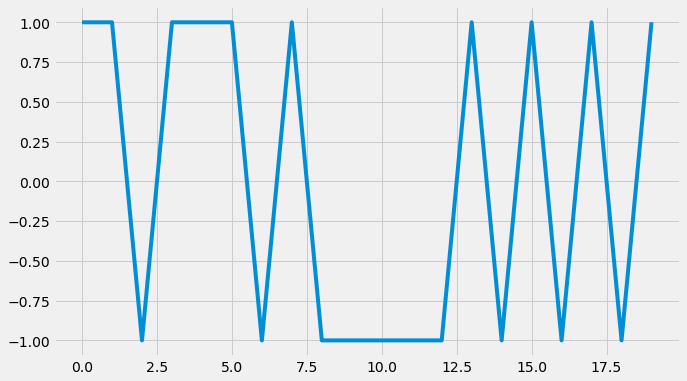

In [64]:
clf.fit(wrcf_gram1)
plt.plot(clf.predict(wrcf_gram1))

## Load saved diagrams

In [10]:
zz_dgms = dill.load(open("dills/zz_dgms.dill", "rb"))
wrcf_dgms = dill.load(open("dills/wrcf_dgms.dill", "rb"))
zz_gram1 = dill.load(open("dills/zz_gram1.dill", "rb"))
wrcf_gram1 = dill.load(open("dills/wrcf_gram1.dill", "rb"))
zz_distmat = dill.load(open("dills/zz_distmat.dill", "rb"))
wrcf_distmat = dill.load(open("dills/wrcf_distmat.dill", "rb"))